# Findings as of 06.20

* ChatGPT had an accuracy of 0.76 (95% CI = [0.72,0.79])
* Human (Initial) had an accuracy of 0.84 (95% CI = [0.80,0.87])
* Human(Final) had an accuracy of 0.97 (95% CI = [0.95,0.98])
* But large differneces across categories: For roughly half of cateogires with frequency above the median, ChatGPT performance indstinguishable to that of Initial Humans
* ChatGPT much worse calibrated than humans
                

From the oracle of Delphi to the predictive analytics industry, humanity has always sought to predict the future. But how much of the future is written in the past? We explore this question literally by asking if large language models -- trained on historical text data -- can forecast future events. Specifically, we compiled a dataset of 439 binary events from the prediction market Metacaculus that occurred after the training window of ChatGPT. We then elicited predictions and confidence in predictions using a zero-shot prompt. We found that ChatGPT can predict the future better than chance, achieving 76% (95% CI = [72%, 79%]) accuracy. But humans still outperform LLMs. At the start of the forecast window, humans  were 84% accurate (95% CI = [80%,87%]), rising to 97% accuracy (95% CI = [95%,98%]) by the very end of the forecast window. Accuracy differed across categories. For example, humans were 29 p.p more accurate than ChatGPT at predicting economic events but only about 2 p.p better than ChatGPT at predicting political events. Notably, for around half of the top 50% most frequently occuring categories (including tech, finance, sports, elections, computing, and geopolitics), the gap in ChatGPT accuracy and initial human forecast accuracy was not significant. However, ChatGPT was worse calibrated (Brier = 0.21) than initial human forecasts (Brier = 0.13) or final human forecasts (Brier = 0.04). In particular, ChatGPT was more overconfidence than humans. We demonstrate that large language models can predict future events at above-chance levels, but these models are still inferior to human forecasters. We release the Delphi400 dataset as a benchmark for the task of predicting the future. Future work should explore how to enhance language models' predictive abilities and calibrate their confidence. Overall, forecasting remains an open challenge in developing more human-like artificial intelligence

# Set up packages

In [409]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.metrics import classification_report, brier_score_loss

random.seed(416)
np.random.seed(416)

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='paper', font_scale=0.8)
    
    if not hex_color_list:
        hex_color_list = [
            "#826AED",  # Medium-bright purple
            "#1B998B",  # Medium-dark teal
            "#D41976",  # Strong pink
            "#81D6E3",  # Bright turquoise blue
            "#DE1A1A",  # Bright red
            "#F2D398",  # Soft, warm beige
            "#136F63",  # Dark green with a hint of blue
            "#F45B69",  # Vibrant pinkish-red
            "#EFAAC4",  # Soft, muted pink
            "#342E37",  # Dark grayish-purple
            "#FBC02D",  # Medium-bright golden yellow
            "#3A3042",  # Dark grayish-purple
            "#2C3531",  # Dark charcoal gray with a green undertone
            "#E87461",  # Medium-bright orange
            "#1C7293"   # Medium-dark blue
        ]
    sns.set_palette(sns.color_palette(hex_color_list))

    plt.rcParams['figure.figsize'] = (3, 2)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
    return hex_color_list
palette = make_aesthetic()


def bootstrap_ci(data, n_bootstrap_samples=10000):
    bootstrap_samples = [resample(data).mean() for _ in range(n_bootstrap_samples)]
    lower = np.percentile(bootstrap_samples, 2.5)
    upper = np.percentile(bootstrap_samples, 97.5)
    return lower, upper

# Read in data

In [410]:
df = pd.read_csv("../../data/clean_llm_preds_and_events.csv")
df['gpt_correct'] = (df['gpt_pred'] == df['resolution'])*1
df['init_correct'] = (df['init_pred'] == df['resolution'])*1
df['final_correct'] = (df['final_pred'] == df['resolution'])*1
print(len(df))
print(df.columns)
display(df.head())

439
Index(['url', 'id', 'title', 'categories', 'publish_time', 'created_time',
       'closed_time', 'resolve_time', 'votes', 'n_forecasters',
       'prediction_count', 'resolution', 'prediction_timeseries',
       'final_pred_time', 'final_pred_conf', 'final_pred_n', 'init_pred_time',
       'init_pred_conf', 'init_pred_n', 'description', 'resolution_criteria',
       'fine_print', 'answer', 'reasoning', 'confidence', 'gpt_pred',
       'gpt_pred_conf', 'init_pred', 'final_pred', 'gpt_correct',
       'init_correct', 'final_correct'],
      dtype='object')


,url,id,title,categories,publish_time,created_time,closed_time,resolve_time,votes,n_forecasters,...,answer,reasoning,confidence,gpt_pred,gpt_pred_conf,init_pred,final_pred,gpt_correct,init_correct,final_correct
0,https://www.metaculus.com/questions/7386/infra...,7386,Will Biden pass an infrastructure package in 2...,"[{'id': 'infrastructure', 'short_name': 'Infra...",2021-10-14T05:00:00Z,2021-06-14T18:18:50.879013Z,2021-12-03T19:14:00Z,2021-11-08T22:00:00Z,6,40,...,YES,Based on my analysis of past infrastructure pa...,0.75,1.0,0.75,1,1,1,1,1
1,https://www.metaculus.com/questions/7816/proto...,7816,Will Tesla reveal a prototype of the Tesla Bot...,"[{'id': 'computing--ai', 'short_name': 'Artifi...",2021-10-02T22:00:00Z,2021-08-23T22:50:24.100690Z,2022-12-31T23:00:00Z,2022-10-01T01:15:00Z,16,151,...,NO,While Tesla has announced plans to develop a h...,0.75,0.0,0.25,0,1,0,0,1
2,https://www.metaculus.com/questions/7871/femal...,7871,Will there be a female Fields Medalist in 2022?,"[{'id': 'math--general', 'short_name': 'Genera...",2022-01-13T05:00:00Z,2021-08-30T22:48:03.655428Z,2022-04-04T04:00:00Z,2022-07-05T16:00:00Z,7,49,...,NO,While there have been a few female Fields Meda...,0.70,0.0,0.30,0,1,0,0,1
3,https://www.metaculus.com/questions/8034/hen-c...,8034,Will the Hen Caging (Prohibition) bill become ...,"[{'id': 'politics--europe', 'short_name': 'Eur...",2021-10-13T23:00:00Z,2021-09-22T17:29:21.661335Z,2022-04-06T23:00:00Z,2022-07-05T16:01:00Z,2,42,...,YES,Based on my analysis of past legislative trend...,0.70,1.0,0.70,0,0,0,1,1
4,https://www.metaculus.com/questions/8054/netan...,8054,Will Netanyahu be Prime Minister of Israel aga...,"[{'id': 'geopolitics', 'short_name': 'Geopolit...",2022-05-23T05:00:00Z,2021-09-26T22:05:05.182729Z,2029-12-31T18:33:00Z,2022-12-29T09:00:00Z,9,82,...,NO,While Netanyahu has been a dominant figure in ...,0.70,0.0,0.30,0,1,0,0,1


# Get classification tables

In [411]:
for _ in ['gpt_pred', 'init_pred', 'final_pred']:
    print(_)
    y_true = df['resolution']
    y_pred = df[_]
    report = classification_report(y_true, y_pred)
    print(report)

gpt_pred
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       332
         1.0       0.50      0.40      0.45       107

    accuracy                           0.76       439
   macro avg       0.66      0.64      0.64       439
weighted avg       0.74      0.76      0.75       439

init_pred
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       332
         1.0       0.66      0.69      0.68       107

    accuracy                           0.84       439
   macro avg       0.78      0.79      0.78       439
weighted avg       0.84      0.84      0.84       439

final_pred
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       332
         1.0       0.90      0.96      0.93       107

    accuracy                           0.97       439
   macro avg       0.95      0.96      0.95       439
weighted avg       0.97      0.97      0.97 

# Graphs

## Overall accuracy

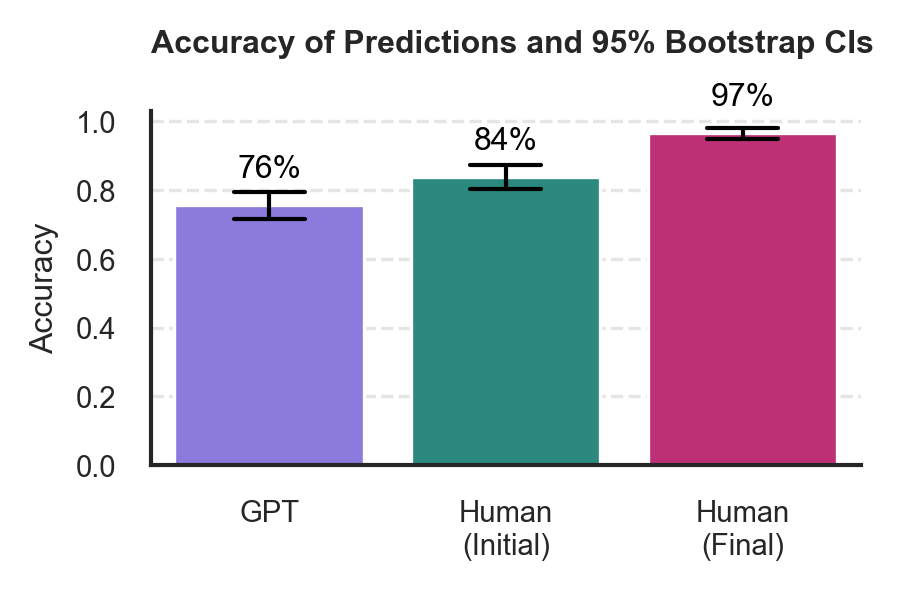

In [412]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

melted = pd.melt(df, value_vars=['gpt_correct', 'init_correct', 'final_correct'], var_name='type', value_name='correct')
melted['type'] = melted['type'].replace({'init_correct': 'Human\n(Initial)', 'final_correct': 'Human\n(Final)', 'gpt_correct': 'GPT'})
sns.barplot(data=melted, x='type', y='correct', ci=95, capsize=0.3, n_boot=10000, errwidth=1, errcolor='black')
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('Accuracy of Predictions and 95% Bootstrap CIs\n')

ax.yaxis.set_major_formatter(PercentFormatter(1))
for i, v in enumerate(accuracy_scores):
    plt.text(i, v +0.08, f'{v:.0%}', ha='center', color='black')

plt.savefig("../../results/accuracy.png")
plt.show()

In [413]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

means = []
n_bootstrap_samples = 10000
for _type in melted['type'].unique():
    type_data = melted[melted['type'] == _type]['correct']
    bootstrap_means = [resample(type_data).mean() for _ in range(n_bootstrap_samples)]
    lower = np.percentile(bootstrap_means, 2.5)
    upper = np.percentile(bootstrap_means, 97.5)
    mean = np.mean(bootstrap_means)
    means.append((_type, mean, lower, upper))
for _type, mean, lower, upper in means:
    print(f"{_type} had an accuracy of {mean:.2f} (95% CI = [{lower:.2f},{upper:.2f}])")


GPT had an accuracy of 0.76 (95% CI = [0.72,0.79])
Human
(Initial) had an accuracy of 0.84 (95% CI = [0.80,0.87])
Human
(Final) had an accuracy of 0.97 (95% CI = [0.95,0.98])


## Brier scores

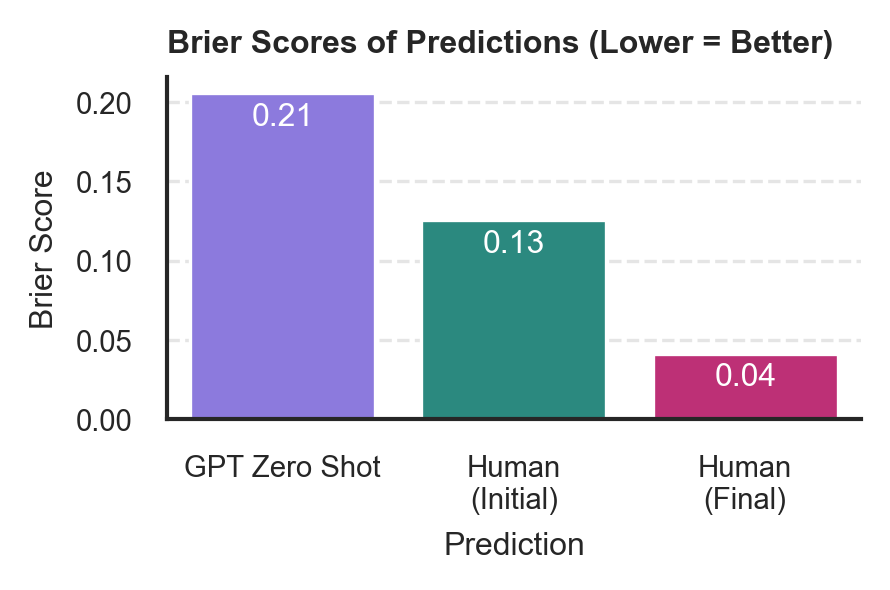

  prediction_labels  brier_scores
0     GPT Zero Shot      0.205290
1  Human\n(Initial)      0.125572
2    Human\n(Final)      0.041331


In [414]:
label_to_colname = {
    'GPT Zero Shot': 'gpt_pred_conf',
    'Human\n(Initial)': 'init_pred_conf',
    'Human\n(Final)': 'final_pred_conf'
}

y_true = df['resolution']
brier_scores = [
    brier_score_loss(y_true, df[colname])
    for label, colname in label_to_colname.items()
]
brier_df = pd.DataFrame({'prediction_labels': list(label_to_colname.keys()), 'brier_scores': brier_scores})
sns.barplot(x='prediction_labels', y='brier_scores', data=brier_df)
plt.xlabel('Prediction')
plt.ylabel('Brier Score')
plt.title('Brier Scores of Predictions (Lower = Better)')
for i, v in enumerate(brier_scores):
    plt.text(i, v - 0.02, f'{v:.2f}', ha='center', color='white')
plt.savefig("../../results/brier.png")

plt.show()

print(brier_df)

## Calibration Curves

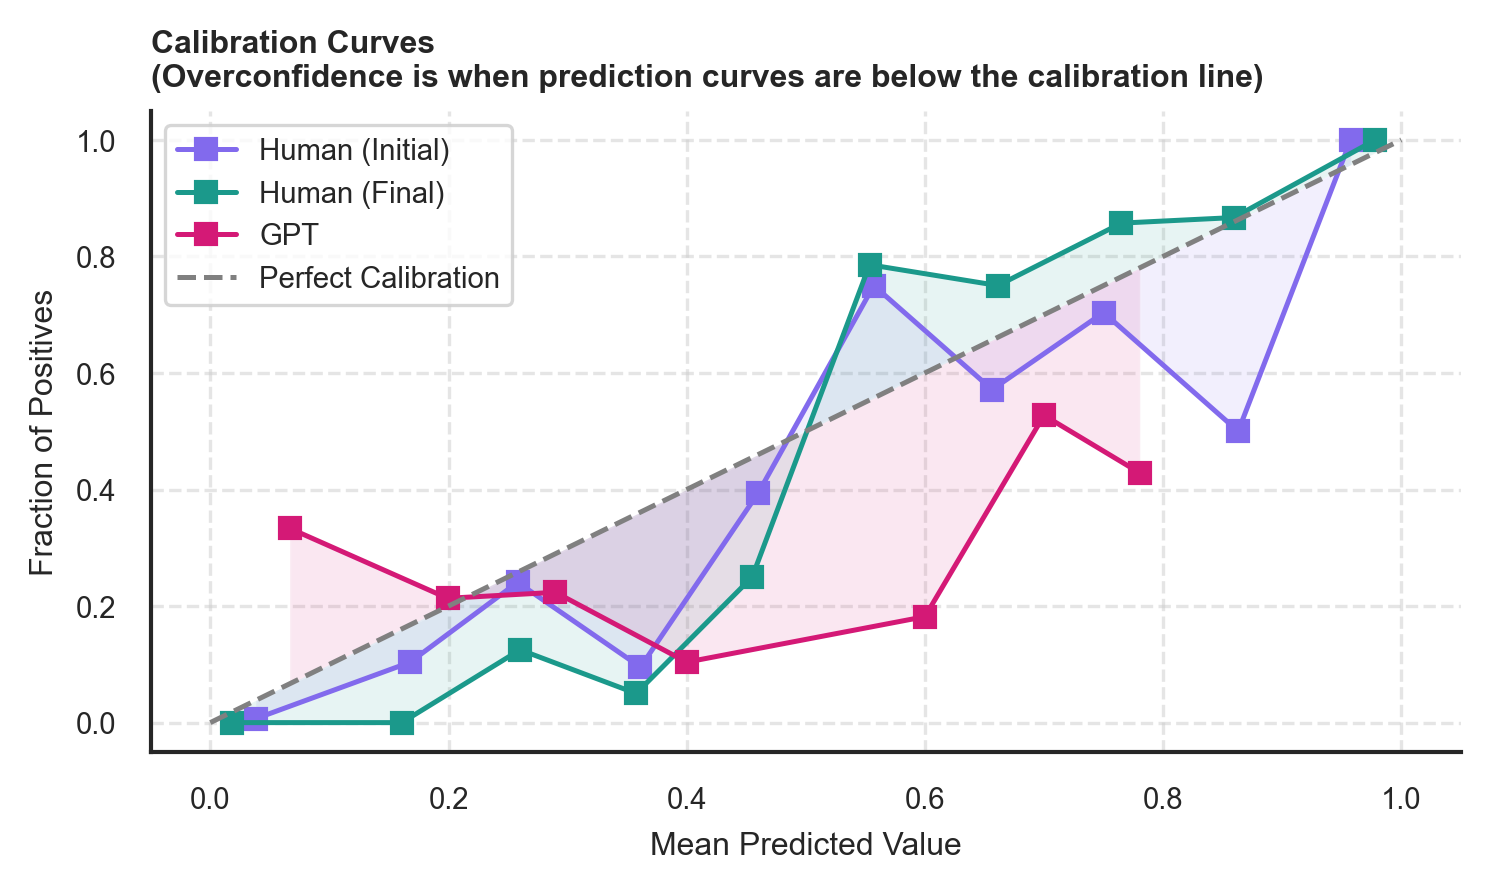

In [415]:
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
pred_dict = {
    'Human (Initial)': 'init_pred_conf',
    'Human (Final)': 'final_pred_conf',
    'GPT': 'gpt_pred_conf'
}

plt.figure(figsize=(5, 3))

for label, y_pred in pred_dict.items():
    fraction_of_positives, mean_predicted_value = calibration_curve(df['resolution'], df[y_pred], n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label=label)
    plt.fill_between(mean_predicted_value, fraction_of_positives, mean_predicted_value, alpha=0.1)

# Add a reference line indicating perfect calibration
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves\n' 
          '(Overconfidence is when prediction curves are below the calibration line)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.savefig("../../results/calibration_curve.png")
plt.show()


# We might think GPT does better for events closer to training window though...

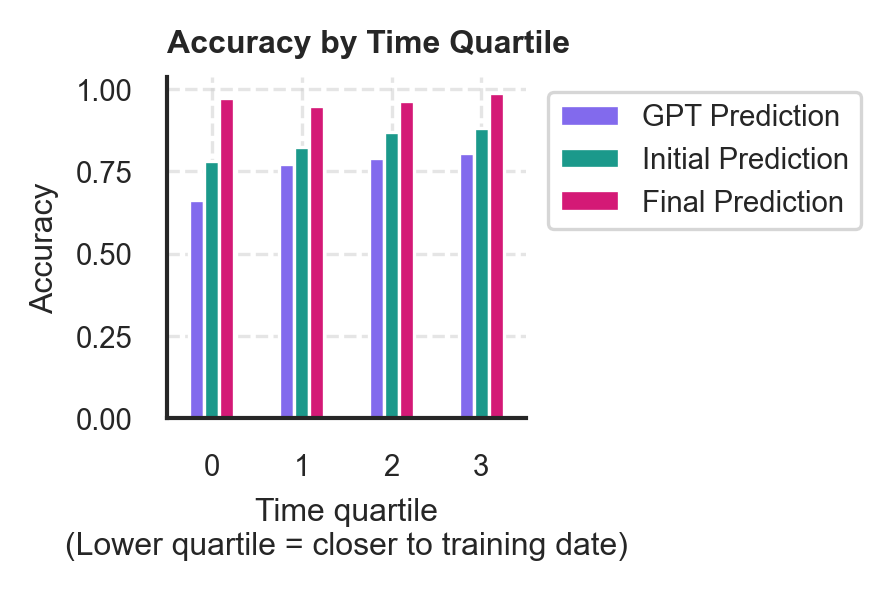

In [416]:
df['gpt_correct'] = (df['gpt_pred'] == df['resolution'])*1
df['init_correct'] = (df['init_pred'] == df['resolution'])*1
df['final_correct'] = (df['final_pred'] == df['resolution'])*1
df['resolve_time'] = pd.to_datetime(df['resolve_time']).dt.tz_localize(None)
target_date = pd.to_datetime('2021-10-01')
df['time_difference'] = (df['resolve_time'] - target_date).dt.days
df['time_q'] = pd.qcut(df['time_difference'], 4, labels=False)


accuracy_by_time_q = df.groupby('time_q')[['gpt_correct', 'init_correct', 'final_correct']].mean()

# Plot the accuracy by time_q
accuracy_by_time_q.plot(kind='bar')
plt.xlabel('Time quartile\n(Lower quartile = closer to training date)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Time Quartile')
plt.xticks(rotation=0, ha='center')
legend = plt.legend(['GPT Prediction', 'Initial Prediction', 'Final Prediction'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig("../../results/acc_by_time.png")

plt.show()

In [52]:
df.groupby(by=['time_q']).median()['time_difference']

time_q
0    231.5
1    381.5
2    457.0
3    484.0
Name: time_difference, dtype: float64

# Look at category heterogenity 

ToDO: Parse these categories better later

## Rehsape data

In [309]:
def get_prefix(categories):
    categories = ast.literal_eval(categories)  # convert string to list of dictionaries
    ids = [cat['id'] for cat in categories]  # get all ids
    prefixes = [i.split('--')[0] if '--' in i else i for i in ids]  # get prefix before '--'
    return prefixes

df['prefixes'] = df['categories'].apply(get_prefix)
df_exploded = df.explode('prefixes')

# grouped_result has columns = ['category', 'gpt_accuracy', 'init_accuracy', 'final_accuracy', 'n']
grouped = df_exploded.groupby('prefixes')
grouped_result = grouped[['gpt_correct', 'init_correct', 'final_correct']].mean()
grouped_result['n'] = grouped.size()
grouped_result.reset_index(inplace=True)
grouped_result.columns = ['category', 'gpt_accuracy', 'init_accuracy', 'final_accuracy', 'n']
grouped_result = grouped_result.sort_values(by='n', ascending=False)


# melted has columns [category, n, type, accuracy]
melted = pd.melt(grouped_result, id_vars=['category', 'n'], value_vars=['gpt_accuracy', 'init_accuracy', 'final_accuracy'], var_name='type', value_name='accuracy')
melted['type'] = melted['type'].map({
    'gpt_accuracy': 'gpt',
    'init_accuracy': 'human_initial',
    'final_accuracy': 'human_final'
})
melted = melted.sort_values(by=['n'], ascending=False)

In [310]:
print(grouped_result['n'].describe())

count     26.000000
mean      29.384615
std       33.184426
min        1.000000
25%        6.000000
50%       16.000000
75%       52.750000
max      112.000000
Name: n, dtype: float64


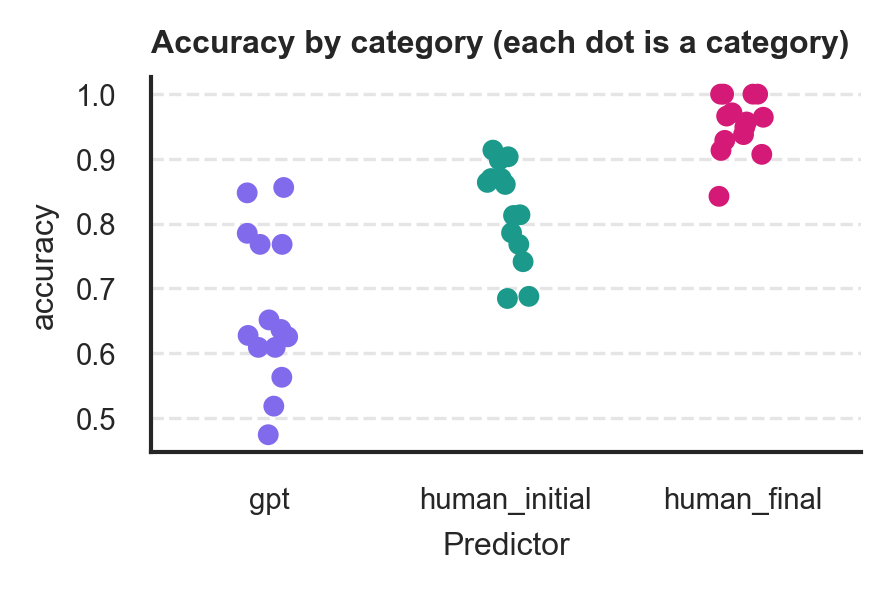

<ipython-input-311-8fcd929f0bf7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['category'] = pd.Categorical(subset['category'], categories=sorted_categories, ordered=True)
/Users/jashkina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


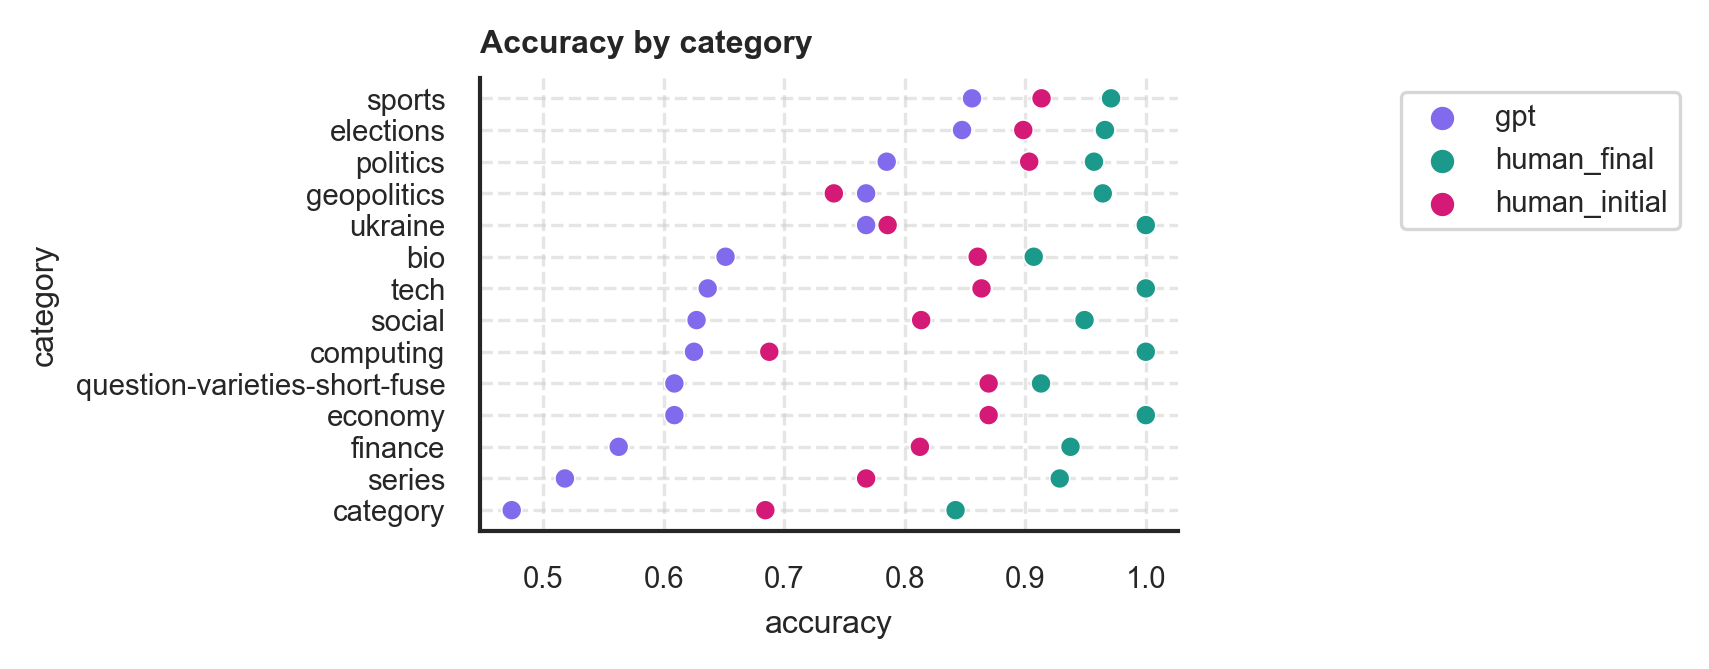

In [311]:
subset = melted.query(f"n >= {grouped_result['n'].median()}")
order = ["gpt", "human_initial", "human_final"] 
####################
# DISTRIBUTIONS
####################
sns.stripplot(data=subset, x='type', y='accuracy', order=order)
plt.title("Accuracy by category (each dot is a category)")
plt.xlabel("Predictor")
plt.show()

####################
# BY CATEGORY
####################
# Create a temporary DataFrame sorted by GPT Prediction accuracy
temp_df = subset[subset['type'] == 'gpt'].sort_values(by='accuracy', ascending=False)
sorted_categories = temp_df['category'].tolist()
subset['category'] = pd.Categorical(subset['category'], categories=sorted_categories, ordered=True)

# Plot the scatterplot
sns.scatterplot(data=subset, y='category', x='accuracy', hue='type')
plt.title("Accuracy by category")
legend = plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
plt.show()



## Compute CIs for each category and plot

In [420]:
def bootstrap_ci(data, n_bootstrap_samples=10000):
    """Calculate bootstrap CI for given data."""
    bootstrap_samples = [resample(data).mean() for _ in range(n_bootstrap_samples)]
    lower = np.percentile(bootstrap_samples, 2.5)
    upper = np.percentile(bootstrap_samples, 97.5)
    return np.mean(data), lower, upper

# has columns ['id', 'prefixes', 'type', 'correct']
df_exploded_melted = df_exploded.melt(id_vars=['id', 'prefixes'], value_vars=['gpt_correct', 'init_correct', 'final_correct'], var_name='type', value_name='correct')
df_melted['type'] = df_melted['type'].map({
    'gpt_correct': 'gpt',
    'init_correct': 'human_initial',
    'final_correct': 'human_final'
})
ci_df = df_exploded_melted.groupby(['prefixes', 'type'])['correct'].apply(bootstrap_ci).reset_index()
ci_df[['mean', 'lower', 'upper']] = pd.DataFrame(ci_df['correct'].tolist(), index=ci_df.index)
ci_df.drop(columns='correct', inplace=True)

# Get only high occuring categories
filtered_ci_df = ci_df[ci_df['prefixes'].isin(subset['category'].tolist())]
filtered_ci_df.head()

,prefixes,type,mean,lower,upper
0,bio,final_correct,0.906977,0.813953,0.976744
1,bio,gpt_correct,0.651163,0.511628,0.790698
2,bio,init_correct,0.860465,0.744186,0.953488
6,category,final_correct,0.842105,0.684211,1.000000
7,category,gpt_correct,0.473684,0.263158,0.684211


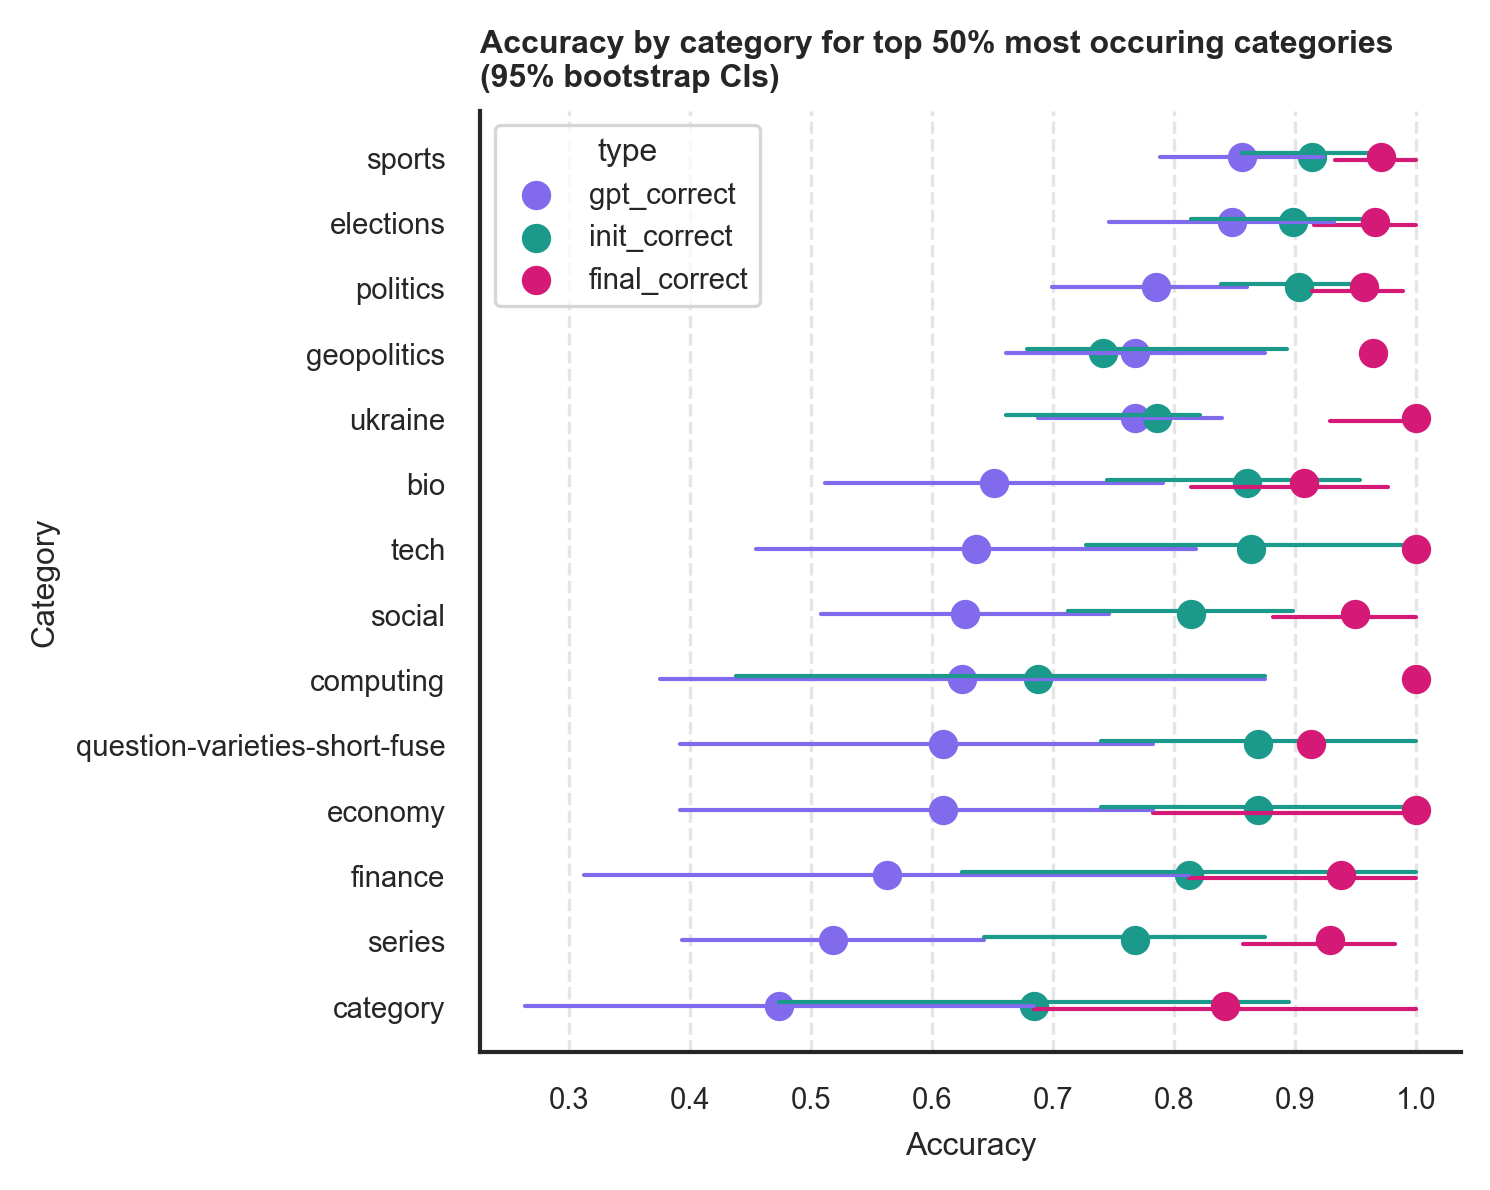

In [424]:
filtered_ci_df = filtered_ci_df.sort_values(by=['type'], ascending=True)
sorted_categories = filtered_ci_df[filtered_ci_df['type'] == 'gpt_correct'].sort_values(by='mean', ascending=False)['prefixes']
filtered_ci_df['prefixes'] = pd.Categorical(filtered_ci_df['prefixes'], categories=sorted_categories, ordered=True)
filtered_ci_df = filtered_ci_df.sort_values(['type', 'prefixes'])

# Define the order of appearance
order = ['gpt_correct', 'init_correct', 'final_correct']

# Make plot
plt.figure(figsize=(5, 4))
pointplot = sns.pointplot(data=filtered_ci_df, x='mean', y='prefixes', hue='type', hue_order=order, ci=False, join=False)

# We have to jitter the points a bit
shift_dict = {'init_correct': -0.05, 'gpt_correct': 0, 'final_correct': 0.05}  # Define a shift for each type
color_dict = {'gpt_correct': palette[0], 'init_correct': palette[1], 'final_correct': palette[2]}

# Define a mapping from category to y-coordinates
y_coords = {category: coord for coord, category in enumerate(sorted_categories)}

# Iterate over DataFrame rows to manually add error bars
for x, y, xlow, xhigh, hue in zip(filtered_ci_df['mean'], filtered_ci_df['prefixes'], filtered_ci_df['lower'], filtered_ci_df['upper'], filtered_ci_df['type']):
    plt.plot((xlow, xhigh), (y_coords[y] + shift_dict[hue], y_coords[y] + shift_dict[hue]), '-', lw=1, alpha=1, color=color_dict[hue])

# Adding title and labels
plt.title("Accuracy by category for top 50% most occuring categories\n(95% bootstrap CIs)")
plt.xlabel("Accuracy")
plt.ylabel("Category")

# Display the plot
plt.tight_layout()
plt.savefig("../../results/ci_categories.png")

plt.show()



# Is GPT on par with humans for anything?

I am not sure if we should be testing H1 or H2:
- H1: HumanInitial and GPT does not differ
- H2: HumanInitial >= GPT

For now I am doing H2

In [439]:
def permutation_test(x, y, n_permutations=10000):
    diff_observed = np.mean(y) - np.mean(x)
    combined = np.concatenate((x, y))
    count = 0
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        new_x, new_y = np.split(combined, [len(x)])
        diff_permuted = np.mean(new_y) - np.mean(new_x)
        
        if diff_permuted >= diff_observed:
            count += 1
    
    p_val = count / n_permutations
    return p_val, diff_observed

# Melt df so it has columns [id, title, prefixes, type, correct]
id_vars = ['id', 'title', 'prefixes']
value_vars = ['gpt_correct', 'init_correct', 'final_correct']
df_melted = pd.melt(df_exploded, id_vars=id_vars, value_vars=value_vars, var_name='type', value_name='correct')
type_mapping = {'gpt_correct': 'gpt', 'init_correct': 'human_initial', 'final_correct': 'human_final'}
df_melted['type'] = df_melted['type'].replace(type_mapping)

# Only look at categories with n greater than median 
df_melted = df_melted[df_melted['prefixes'].isin(subset['category']).tolist()]

# Iterate through unique categories and do the permutation test
results = []
unique_categories = df_melted['prefixes'].unique()
for category in unique_categories:
    gpt_data = df_melted.loc[(df_melted['prefixes'] == category) & (df_melted['type'] == 'gpt'), 'correct']
    human_initial_data = df_melted.loc[(df_melted['prefixes'] == category) & (df_melted['type'] == 'human_initial'), 'correct']
    p_val, diff_observed = permutation_test(gpt_data, human_initial_data)
    results.append((category, p_val, diff_observed))
pdf = pd.DataFrame(results, columns=['category', 'p_val', 'obs_diff'])
pdf.sort_values(by=['p_val'], ascending=False)


,category,p_val,obs_diff
5,geopolitics,0.7381,-0.026786
13,ukraine,0.5077,0.017857
1,computing,0.5021,0.062500
9,elections,0.2944,0.050847
10,category,0.1587,0.210526
11,sports,0.1384,0.057692
6,finance,0.1286,0.250000
2,tech,0.0803,0.227273
12,question-varieties-short-fuse,0.0480,0.260870
7,economy,0.0468,0.260870


In [440]:
num_categories_above_median = len(pdf)
num_indistinguishable = len(pdf.query("p_val >= 0.05"))
print(f"There are {num_categories_above_median} categories above the median. ChatGPT is indistinguishable for {num_indistinguishable} of them.")

There are 14 categories above the median. ChatGPT is indistinguishable for 8 of them.


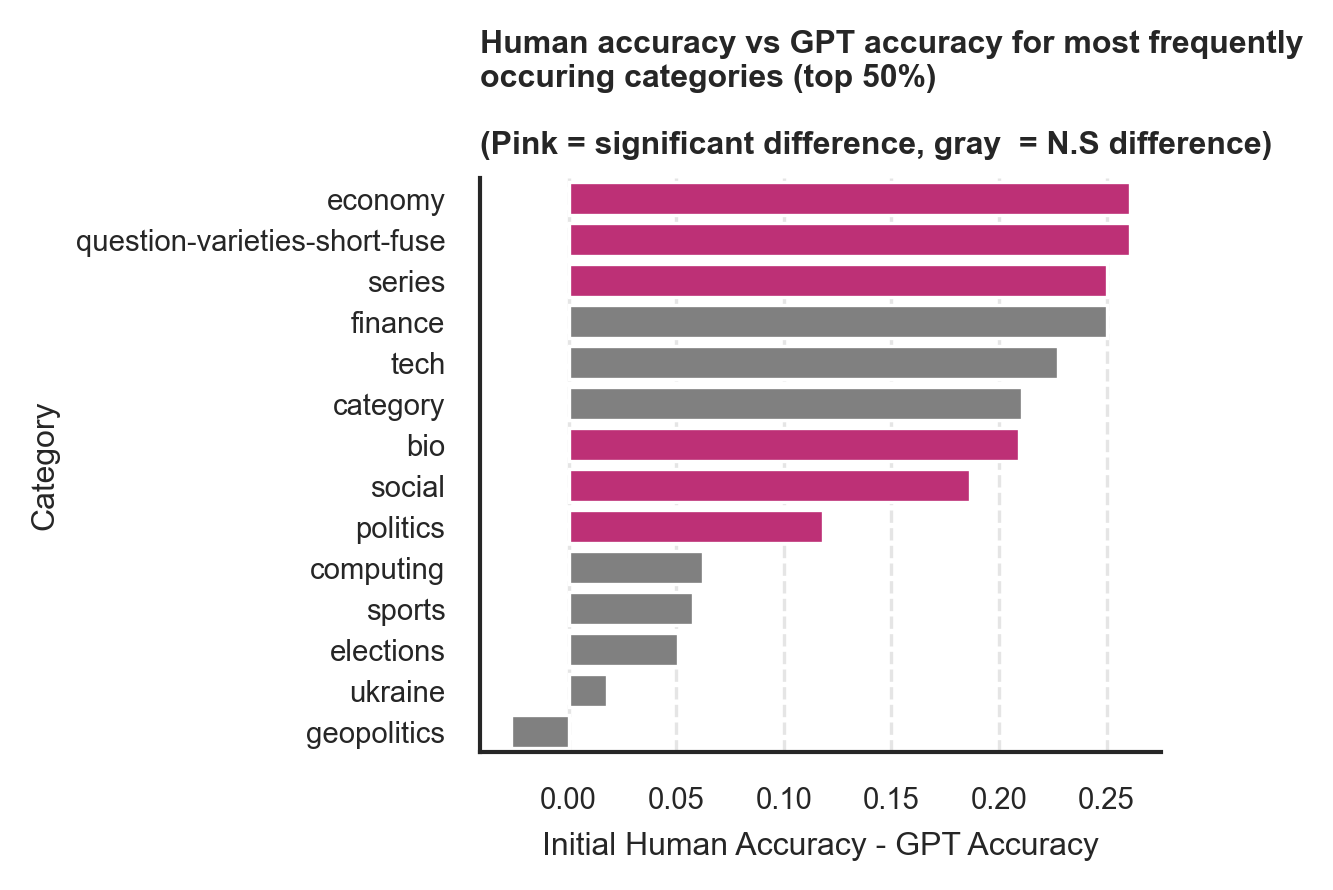

In [441]:
pdf = pdf.sort_values(by='obs_diff', ascending=False)
make_aesthetic()
plt.figure(figsize=(4,3))
sns.barplot(data=pdf, y='category', x='obs_diff', palette=['#D41976' if p_val <= 0.05 else 'gray' for p_val in pdf['p_val']])
plt.xlabel("Initial Human Accuracy - GPT Accuracy")
plt.ylabel("Category")
plt.title("Human accuracy vs GPT accuracy for most frequently\noccuring categories (top 50%) \n\n(Pink = significant difference, gray  = N.S difference)")
plt.savefig("../../results/sig_diff_cat.png")
plt.show()